In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from LoadData import loaddata, filter_zeroes

simulation_names = ['Eagle', 'Illustris', 'IllustrisTNG', 'Mufasa', 'Simba', 'SC-Sam', 'UniverseMachine', 'Fire-2', 'Marvel_JL']
data = loaddata(simulation_names)

inputHistories = np.array([element[0] for element in data])
mass_presentsfr = np.array([element[1] for element in data])
labels = np.array([element[2] for element in data])

for i in range(len(labels)):
    if labels[i] == 'Eagle':
        labels[i] = 0
    elif labels[i] == 'Illustris':
        labels[i] = 1
    elif labels[i] == 'IllustrisTNG':
        labels[i] = 2
    elif labels[i] == 'Mufasa':
        labels[i] = 3
    elif labels[i] == 'Simba':
        labels[i] = 4
    elif labels[i] == 'SC-Sam':
        labels[i] = 5
    elif labels[i] == 'UniverseMachine':
        labels[i] = 6
    elif labels[i] == 'Fire-2':
        labels[i] = 7
    elif labels[i] == 'Marvel_JL':
        labels[i] = 8
labels = np.array(labels).astype('float32')


filtered_inputHistories, filtered_mass_presentsfr, filtered_labels = filter_zeroes(inputHistories, mass_presentsfr, labels)

In [2]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(filtered_inputHistories, filtered_labels, test_size=0.2, random_state=42)

# Normalize the star formation histories
X_train = [(sfh / (np.trapz(sfh)) * 500) for sfh in X_train]  # Normalize SFH
X_test = [(sfh / (np.trapz(sfh)) * 500) for sfh in X_test]    # Normalize SFH

X_train = np.array(X_train)
X_test = np.array(X_test)

# Further split the training data into 80% (64%) training and 20% (16%) validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)  

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

device = "cpu"
print(f"Using {device} device")

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32) 
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

Using cpu device


**The first 100 SFHs:**

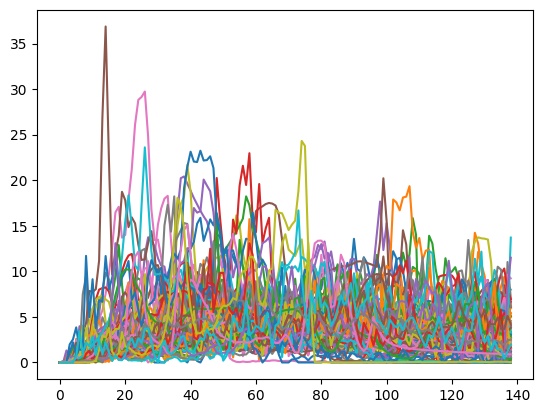

In [4]:
for i in range(100):
    plt.plot(X_train_tensor[i])

In [5]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Define the neural network
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=4, padding=1)  
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=4, padding=1)
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=5, padding=1)
        self.conv4 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=5, padding=1)  
        self.pool = nn.MaxPool1d(2, 2)  
        self.fc1 = nn.Linear(16 * 7, 64)  
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        
        # Decoder
        self.fc4 = nn.Linear(16, 32)
        self.fc5 = nn.Linear(32, 64)
        self.fc6 = nn.Linear(64, 16 * 7)
        self.deconv1 = nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=4, stride=2)
        self.deconv2 = nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=4, stride=2)
        self.deconv3 = nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=3, stride=2)
        self.deconv4 = nn.ConvTranspose1d(in_channels=16, out_channels=1, kernel_size=3, stride=2)
        
    def encoder(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))  
        x = x.view(-1, 16 * 7)  # Matching new dimensions after convolutions and pooling
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        encoded = torch.relu(self.fc3(x))
        return encoded

    def decoder(self, x):
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = x.view(-1, 16, 7)
        x = torch.relu(self.deconv1(x))
        x = torch.relu(self.deconv2(x))
        x = torch.relu(self.deconv3(x))
        x = torch.relu(self.deconv4(x))
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Create the model instance
AE = ConvAutoencoder().to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Assuming regression task with MSE loss
optimizer = optim.Adam(AE.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)

# Create a DataLoader for batch processing
dataset = TensorDataset(X_train_tensor.unsqueeze(1), y_train_tensor)
dataloader = DataLoader(dataset, batch_size=200, shuffle=True)

val_dataset = TensorDataset(X_val_tensor.unsqueeze(1), y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=200, shuffle=False)

In [6]:
print(AE)

ConvAutoencoder(
  (conv1): Conv1d(1, 16, kernel_size=(4,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 16, kernel_size=(4,), stride=(1,), padding=(1,))
  (conv3): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(1,))
  (conv4): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=112, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=112, bias=True)
  (deconv1): ConvTranspose1d(16, 16, kernel_size=(4,), stride=(2,))
  (deconv2): ConvTranspose1d(16, 16, kernel_size=(4,), stride=(2,))
  (deconv3): ConvTranspose1d(16, 16, kernel_size=(3,), stride=(2,))
  (deconv4): ConvTranspose1d(16, 1, kernel_size=(

In [7]:
# Training loop
num_epochs = 800
losses = [] # To store training losses
val_losses = []  # To store validation losses

for epoch in range(num_epochs):
    loss = 0.0
    for data in dataloader:
        inputs, _ = data
        optimizer.zero_grad()
        outputs = AE(inputs)
        curr_loss = criterion(outputs, inputs) # Comparing output to input for autoencoder
        curr_loss.backward()
        optimizer.step()
        loss += curr_loss.item()

    loss /= len(dataloader)
    losses.append(loss)
    
    AE.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_dataloader:
            val_inputs, _ = data
            val_outputs = AE(val_inputs)
            val_loss += criterion(val_outputs, val_inputs).item() # Comparing validation output and input
    
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    

    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Training Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')
    # tell scheduler to consider updating learning rate
    scheduler.step()

print('Training complete')

Epoch [0/800], Training Loss: 9.8338, Val Loss: 5.2076
Epoch [10/800], Training Loss: 2.3202, Val Loss: 2.2305
Epoch [20/800], Training Loss: 2.0233, Val Loss: 2.0020
Epoch [30/800], Training Loss: 1.8860, Val Loss: 1.8815
Epoch [40/800], Training Loss: 1.8491, Val Loss: 1.8609
Epoch [50/800], Training Loss: 1.8134, Val Loss: 1.8150
Epoch [60/800], Training Loss: 1.7210, Val Loss: 1.7584
Epoch [70/800], Training Loss: 1.7113, Val Loss: 1.6985
Epoch [80/800], Training Loss: 1.6774, Val Loss: 1.6744
Epoch [90/800], Training Loss: 1.6641, Val Loss: 1.6918
Epoch [100/800], Training Loss: 1.6621, Val Loss: 1.6710
Epoch [110/800], Training Loss: 1.6399, Val Loss: 1.6485
Epoch [120/800], Training Loss: 1.6694, Val Loss: 1.6374
Epoch [130/800], Training Loss: 1.6070, Val Loss: 1.6170
Epoch [140/800], Training Loss: 1.6072, Val Loss: 1.5970
Epoch [150/800], Training Loss: 1.5507, Val Loss: 1.5638
Epoch [160/800], Training Loss: 1.5364, Val Loss: 1.5516
Epoch [170/800], Training Loss: 1.5554, Va

In [33]:
AE = torch.load('AE Models/torch1.66autoencodervalmodel.pth')
print(AE)

ConvAutoencoder(
  (conv1): Conv1d(1, 16, kernel_size=(4,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 16, kernel_size=(4,), stride=(1,), padding=(1,))
  (conv3): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(1,))
  (conv4): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=112, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=112, bias=True)
  (deconv1): ConvTranspose1d(16, 16, kernel_size=(4,), stride=(2,))
  (deconv2): ConvTranspose1d(16, 16, kernel_size=(4,), stride=(2,))
  (deconv3): ConvTranspose1d(16, 16, kernel_size=(3,), stride=(2,))
  (deconv4): ConvTranspose1d(16, 1, kernel_size=(

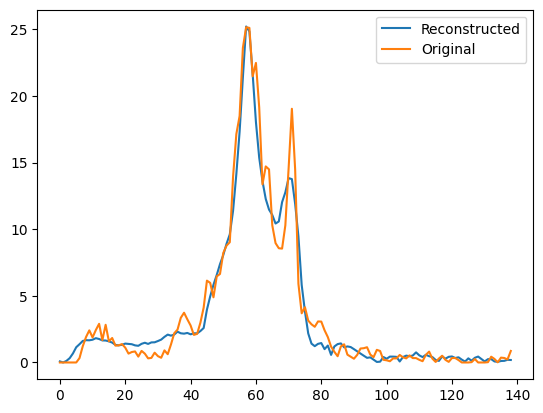

In [8]:
i = 2132
plt.plot(AE(X_val_tensor[i].unsqueeze(0).unsqueeze(0))[0][0].detach().numpy())
plt.plot(X_val_tensor[i].unsqueeze(0).unsqueeze(0)[0][0].detach().numpy())
plt.legend(['Reconstructed', 'Original'])

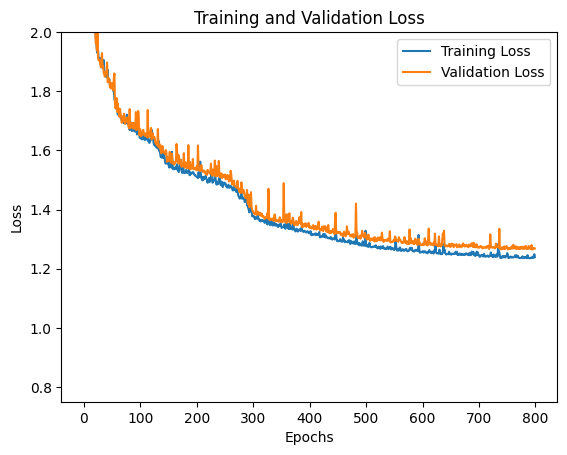

In [9]:
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0.75,2)
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

np.save('AE Losses/32lat0.917loss.npy', val_losses)

In [10]:
torch.save(AE, 'AE Models/16lat1.269loss.pth')

In [11]:
generated_SFHs = AE(X_test_tensor.unsqueeze(1))
real_SFHs = X_test_tensor.unsqueeze(1)

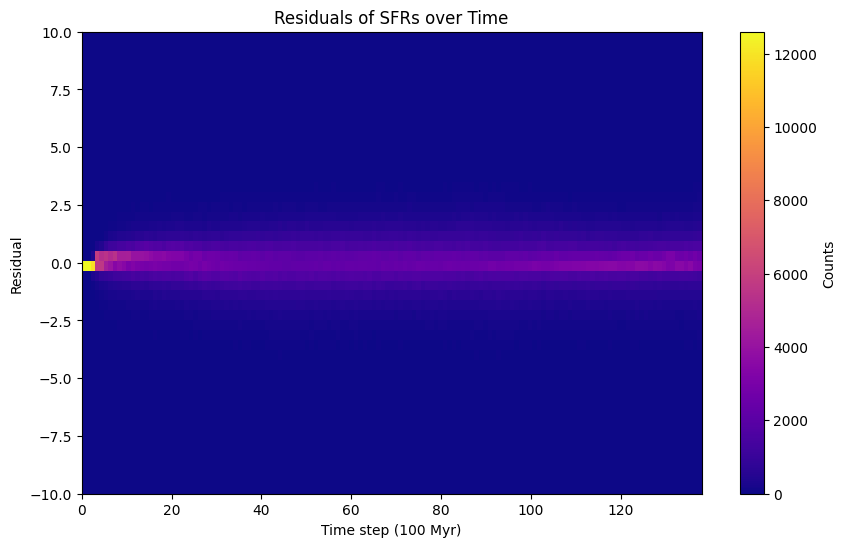

In [12]:
# Calculate residuals
residuals = (generated_SFHs - real_SFHs).detach().numpy().squeeze()

# Create time axis
time_axis = np.tile(np.arange(residuals.shape[1]), residuals.shape[0])

# Flatten the residuals
residuals_flat = residuals.flatten()

# Create a 2D histogram
plt.figure(figsize=(10, 6))
plt.hist2d(time_axis, residuals_flat, bins=[139, 200], cmap='plasma')
plt.ylim(-10,10)
plt.colorbar(label='Counts')
plt.xlabel('Time step (100 Myr)')
plt.ylabel('Residual')
plt.title('Residuals of SFRs over Time')
plt.show()

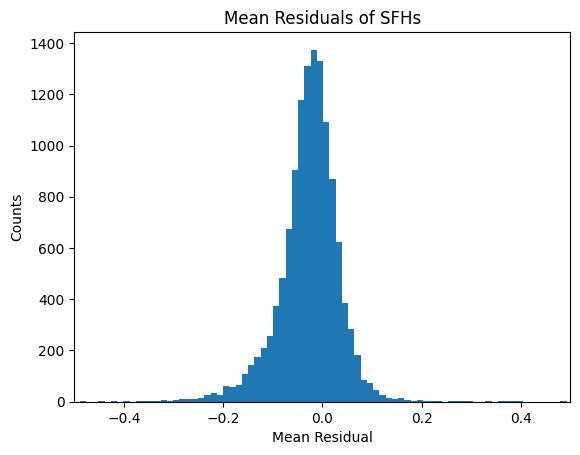

In [13]:
plt.hist([np.mean(residual) for residual in residuals], bins=150)
plt.xlabel('Mean Residual')
plt.ylabel('Counts')
plt.title('Mean Residuals of SFHs')
plt.xlim(-0.5, 0.5)
plt.show()

In [14]:
latent_space = AE.encoder(X_test_tensor.unsqueeze(1)).detach().numpy()

In [15]:
import umap
reducer = umap.UMAP(n_components=2, min_dist=0.1, n_neighbors=20)
embedding = reducer.fit_transform(latent_space)
embedding.shape

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(12621, 2)

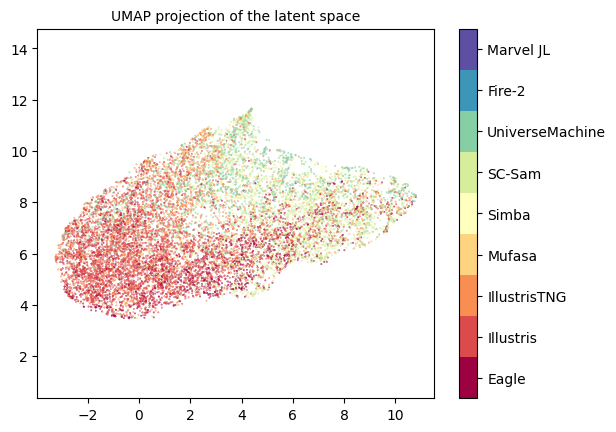

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a list of string labels
labels = ['Eagle', 'Illustris', 'IllustrisTNG', 'Mufasa', 'Simba', 'SC-Sam', 'UniverseMachine', 'Fire-2', 'Marvel JL']

plt.scatter(embedding[:, 0], embedding[:, 1], c=y_test_tensor, cmap='Spectral', s=0.1)
plt.gca().set_aspect('equal', 'datalim')

# Create a colorbar
cbar = plt.colorbar(boundaries=np.arange(10)-0.5, ticks=np.arange(9))

# Set the colorbar labels
cbar.ax.set_yticklabels(labels)

plt.title('UMAP projection of the latent space', fontsize=10)
plt.show()